<a href="https://colab.research.google.com/github/athulrj02/DeepDuel/blob/main/ML%7CCA_Two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pip install tensorflow

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/MLPR Images'

In [6]:
# Verifying dataset path
if os.path.exists(dataset_path):
    print("Dataset path verified.")
else:
    print("Error: Dataset path not found!")

Dataset path verified.


In [8]:
# List files and directories in the dataset path
for root, dirs, files in os.walk(dataset_path):
  print(f"Found {len(dirs)} directories and {len(files)} files in '{root}'.")
  if dirs:
    print("Subdirectories:", dirs)
  if files:
    print("Example files:", files[:5])

['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5', 'Background']
Found 6 directories and 0 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images'.
Subdirectories: ['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5', 'Background']
Found 0 directories and 500 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images/Product_1'.
Example files: ['1500284916.jpg', '1500277597.jpg', '1500285311.jpg', '1500283844.jpg', '1500277274.jpg']
Found 0 directories and 14 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images/Product_2'.
Example files: ['1500276485.jpg', '1500276500.jpg', '1500276507.jpg', '1500276516.jpg', '1500276559.jpg']
Found 0 directories and 400 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images/Product_3'.
Example files: ['1500275183.jpg', '1500275458.jpg', '1500275226.jpg', '1500275336.jpg', '1500275563.jpg']
Found 0 directories and 385 files in '/content/drive/My Drive/Colab Notebooks/MLPR Images/Product_4'.
Example f

In [ ]:
# !pip install tensorflow numpy matplotlib opencv-python scikit-learn

Analyzing Dataset and Checking Class Distribution

In [9]:
import cv2
from collections import Counter

In [10]:
# Defining function to count the number of images per class
def count_images_in_classes(dataset_path):
  class_counts = {}
  for subdir in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, subdir)
    if os.path.isdir(class_dir):
      class_counts[subdir] = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
  return class_counts

In [11]:
# Get class distribution
class_distribution = count_images_in_classes(dataset_path)

In [12]:
# class distribution
print("Class Distribution:")
for class_name, count in class_distribution.items():
    print(f"Class '{class_name}': {count} images")

Class Distribution:
Class 'Product_1': 500 images
Class 'Product_2': 14 images
Class 'Product_3': 400 images
Class 'Product_4': 385 images
Class 'Product_5': 600 images
Class 'Background': 39 images


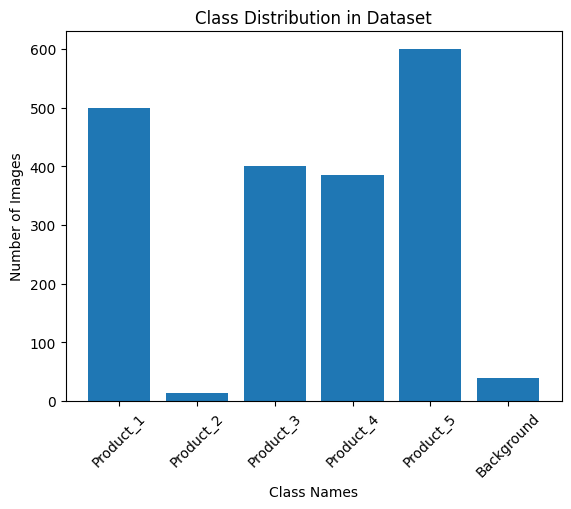

In [13]:
# Visualize class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xticks(rotation=45)
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

Preprocessing with Augmentation for Imbalanced Classes

In [14]:
# Data preprocessing
image_size = (128, 128)  # Resize all images to this size
X = []
y = []

In [15]:
# Define a function for data augmentation
def augment_image(image):
  datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode="nearest",
    )
  image = image.reshape((1, *image_size, 3))
  augmented_images = [datagen.flow(image, batch_size=1).next()[0].astype(np.uint8) for _ in range(5)]
  return augmented_images

In [16]:
# Load and augment images
for label, class_name in enumerate(class_distribution.keys()):
  class_dir = os.path.join(dataset_path, class_name)
  for file_name in os.listdir(class_dir):
    file_path = os.path.join(class_dir, file_name)
    try:
      # Load image
      image = cv2.imread(file_path)
      image = cv2.resize(image, image_size)  # Resize image
      X.append(image)
      y.append(label)

      # Augment underrepresented classes
      if class_name in ['Product_2', 'Background'] and len(X) < 200:
        augmented_images = augment_image(image)
        X.extend(augmented_images)
        y.extend([label] * len(augmented_images))
    except Exception as e:
      print(f"Error loading {file_name}: {e}")

In [17]:
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

In [18]:
# Normalize pixel values
X = X / 255.0

In [19]:
# One-hot encode labels
y = to_categorical(y)

In [20]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [21]:
print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Test data: {X_test.shape}, {y_test.shape}")

Training data: (1356, 128, 128, 3), (1356, 6)
Validation data: (291, 128, 128, 3), (291, 6)
Test data: (291, 128, 128, 3), (291, 6)


#**CNN MODEL**

In [22]:
# Define CNN model
cnn_model = Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
#model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# computed class weights
class_weights = {0: 0.646, 1: 23.071428571428573, 2: 0.8075, 3: 0.8389610389610389, 4: 0.5383333333333333, 5: 8.282051282051283}

In [26]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4144 - loss: 1.5258 - val_accuracy: 0.8179 - val_loss: 0.4874
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8196 - loss: 0.5216 - val_accuracy: 0.9450 - val_loss: 0.2192
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8906 - loss: 0.3393 - val_accuracy: 0.9347 - val_loss: 0.1835
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9020 - loss: 0.2861 - val_accuracy: 0.9622 - val_loss: 0.1172
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9440 - loss: 0.1873 - val_accuracy: 0.9691 - val_loss: 0.1206
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9291 - loss: 0.1985 - val_accuracy: 0.9828 - val_loss: 0.0770
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9476 - loss: 0.1493 - val_accuracy: 0.9863 - val_loss: 0.0663
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9665 - loss: 0.1142 - val_accuracy: 0.9863 - val_loss:

In [27]:
# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.9761 - loss: 0.1112
Test Accuracy: 0.96


#**Transfer Learning**

**Transfer Learning using pretrained model VGG16**

In [28]:
# Load pre-trained VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [29]:
# Freeze base model layers to retain pre-trained weights
base_model.trainable = False

In [30]:
# craeting model
transfer_model = Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])

In [31]:
transfer_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 2,098,950 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
# Compile the transfer learning model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
# TranferLearning model | Training
history_transfer = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 349s 8s/step - accuracy: 0.6236 - loss: 1.3648 - val_accuracy: 0.9622 - val_loss: 0.1180
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 378s 8s/step - accuracy: 0.9444 - loss: 0.1859 - val_accuracy: 0.9828 - val_loss: 0.0771
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.9425 - loss: 0.1788 - val_accuracy: 0.9828 - val_loss: 0.0638
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 402s 9s/step - accuracy: 0.9680 - loss: 0.1156 - val_accuracy: 0.9794 - val_loss: 0.0644
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 383s 9s/step - accuracy: 0.9652 - loss: 0.0984 - val_accuracy: 0.9794 - val_loss: 0.0524


In [34]:
# Evaluate the model on test data
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(X_test, y_test)
print(f"Test Accuracy (Transfer Learning): {test_accuracy_transfer:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.9625 - loss: 0.1538
Test Accuracy (Transfer Learning): 0.95


Visualizing predictions for CNN Model:
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step


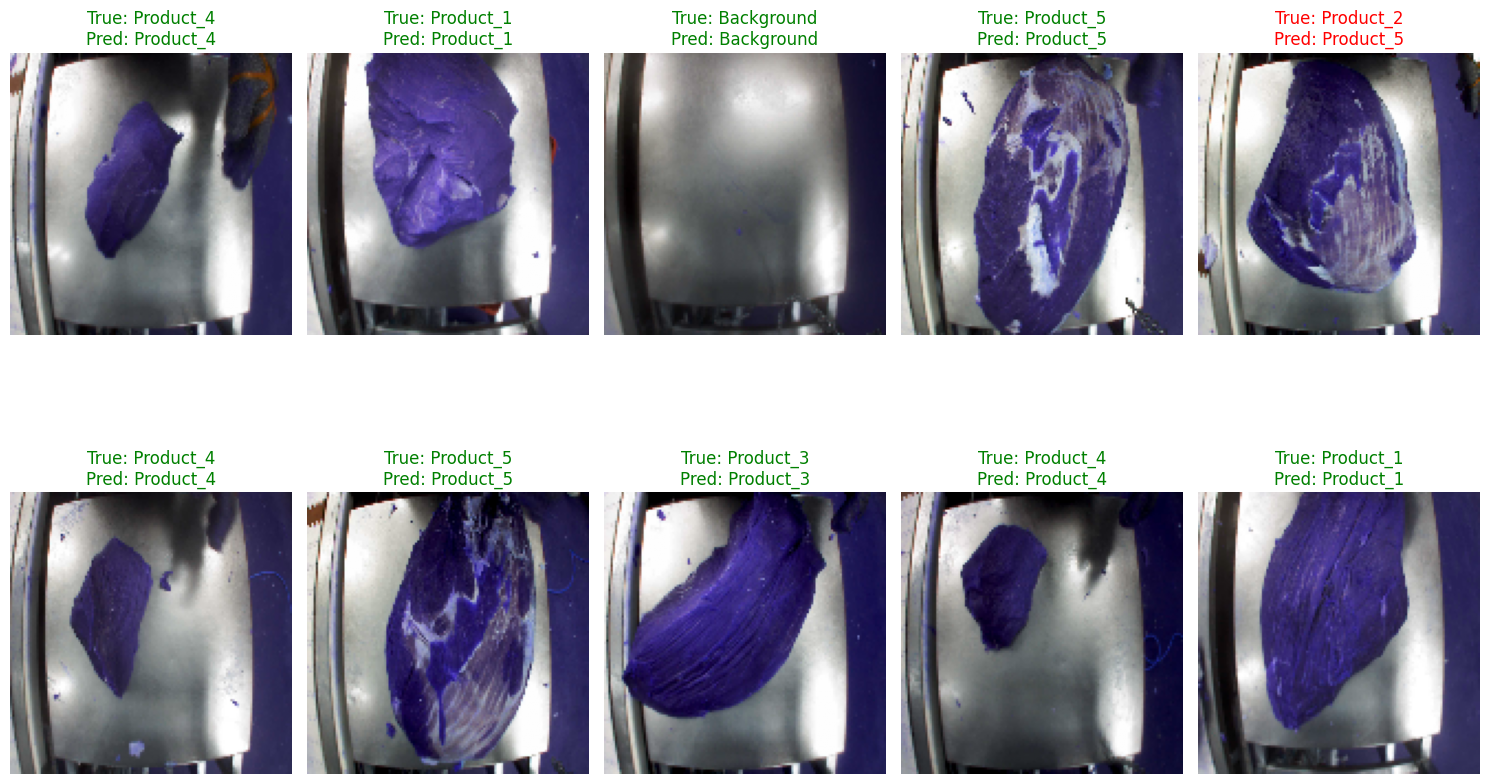

Visualizing predictions for Transfer Learning Model:
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step


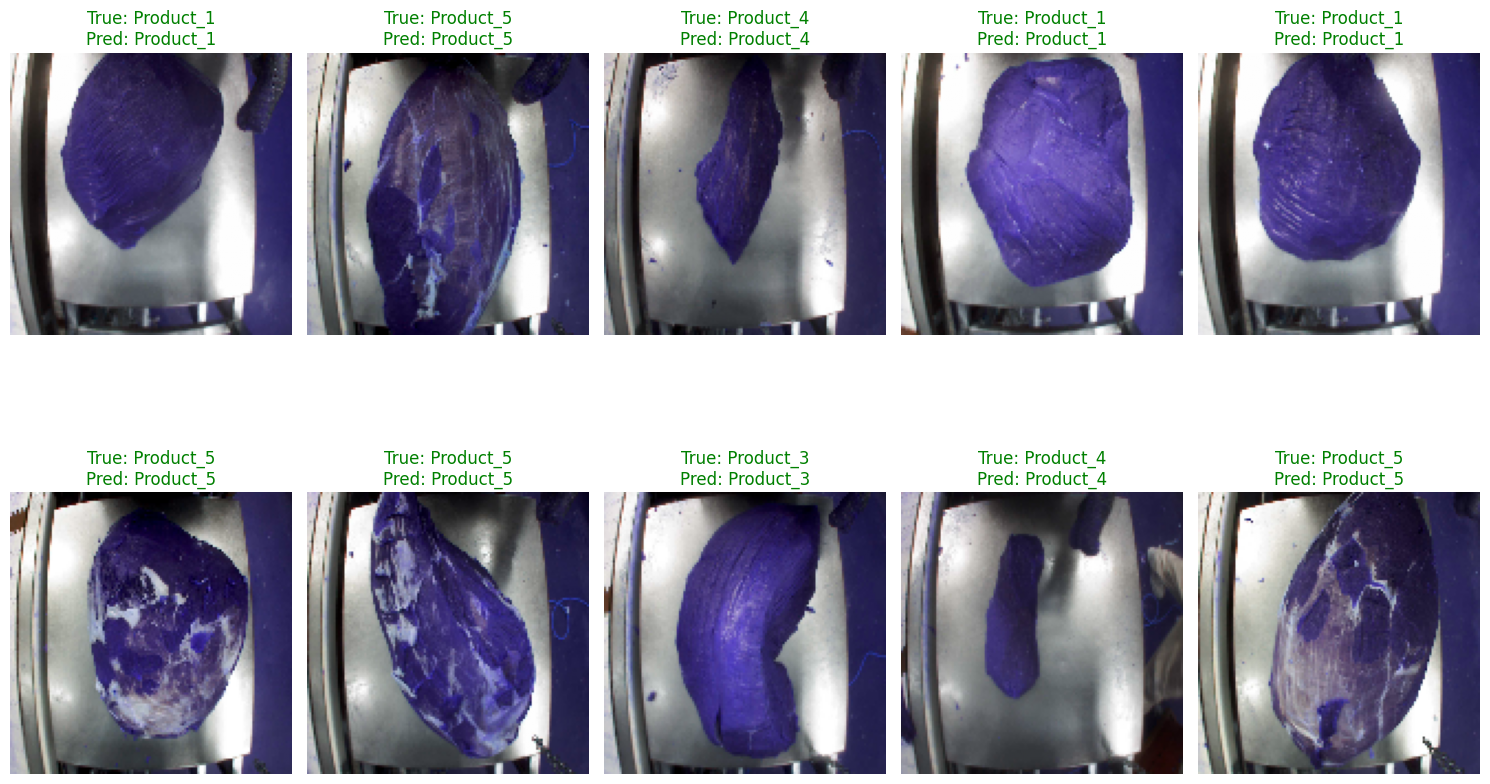

In [35]:
# Define a function to visualize predictions
def visualize_predictions(model, X_test, y_test, class_names, num_images=10):
  # Get predictions
  predictions = model.predict(X_test)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(y_test, axis=1)

  # Select random indices for visualization
  indices = np.random.choice(len(X_test), num_images, replace=False)

  plt.figure(figsize=(15, 10))
  for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    true_class = class_names[true_labels[idx]]
    predicted_class = class_names[predicted_labels[idx]]
    color = "green" if true_class == predicted_class else "red"
    plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)
  plt.tight_layout()
  plt.show()

# Class names based on the dataset
class_names = list(class_distribution.keys())

# Visualize predictions for CNN Model
print("Visualizing predictions for CNN Model:")
visualize_predictions(cnn_model, X_test, y_test, class_names)

# Visualize predictions for Transfer Learning Model
print("Visualizing predictions for Transfer Learning Model:")
visualize_predictions(transfer_model, X_test, y_test, class_names)


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define function to compute metrics
def evaluate_model(model, X_test, y_test, class_names):
  # Get predictions
  predictions = model.predict(X_test)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(y_test, axis=1)

  # Classification report
  report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)
  print("Classification Report:\n", report)

  # Confusion matrix
  conf_matrix = confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

Metrics for CNN Model:
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step
Classification Report:
               precision    recall  f1-score   support

   Product_1     1.0000    0.9067    0.9510        75
   Product_2     0.0000    0.0000    0.0000         2
   Product_3     0.8806    0.9833    0.9291        60
   Product_4     1.0000    1.0000    1.0000        58
   Product_5     0.9674    0.9889    0.9780        90
  Background     1.0000    1.0000    1.0000         6

    accuracy                         0.9622       291
   macro avg     0.8080    0.8131    0.8097       291
weighted avg     0.9584    0.9622    0.9591       291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


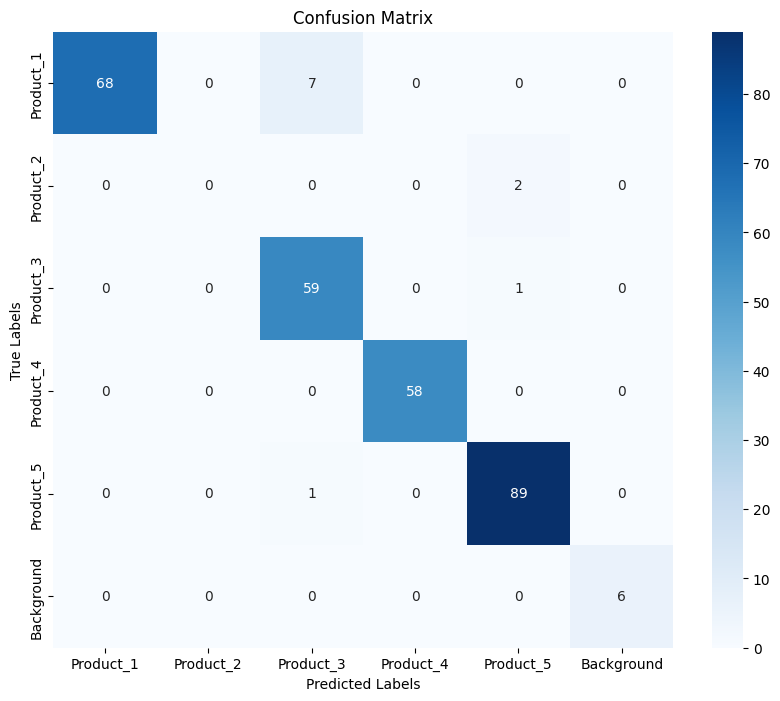

In [37]:
# Evaluate CNN Model
print("Metrics for CNN Model:")
evaluate_model(cnn_model, X_test, y_test, class_names)

Metrics for Transfer Learning Model:
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

   Product_1     1.0000    0.8933    0.9437        75
   Product_2     0.0000    0.0000    0.0000         2
   Product_3     0.8889    0.9333    0.9106        60
   Product_4     0.9667    1.0000    0.9831        58
   Product_5     0.9474    1.0000    0.9730        90
  Background     1.0000    1.0000    1.0000         6

    accuracy                         0.9519       291
   macro avg     0.8005    0.8044    0.8017       291
weighted avg     0.9473    0.9519    0.9484       291



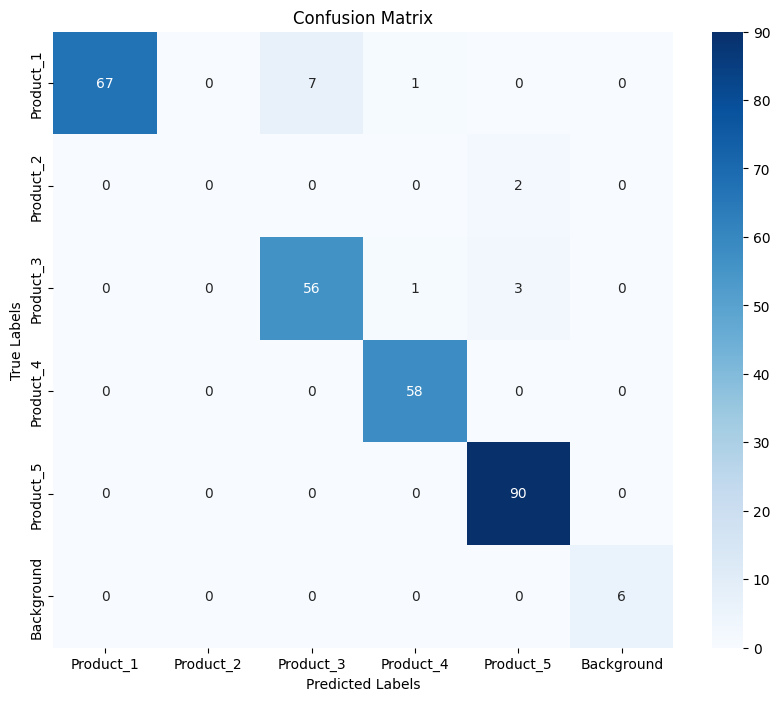

In [38]:
# Evaluate Transfer Learning Model
print("Metrics for Transfer Learning Model:")
evaluate_model(transfer_model, X_test, y_test, class_names)